In [19]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# General imports
import json
import os
from qiskit import QuantumCircuit
import numpy as np
from dataclasses import dataclass
from enum import auto, Enum

In [21]:
@dataclass
class SchedulerType(Enum):
    """The type of scheduler to use."""

    BASELINE = auto()
    SIMPLE = auto()
    EXTENDED = auto()  

In [22]:

# Find the type of algorithm
typeAlgorithm = os.listdir('component/d_scheduling/algorithm')
cleantypeAlgorithm = [item for item in typeAlgorithm if item not in ['__pycache__', '__init__.py']]
# make clean typeAlgorithm
dictAlgorithm = {}
for item in cleantypeAlgorithm:
    dictAlgorithm[item] = os.listdir('component/d_scheduling/algorithm/' + item)
    # make clean nameAlgorithm
    cleandictAlgorithm = [item for item in dictAlgorithm[item] if item not in ['__pycache__', '__init__.py']]
    dictAlgorithm[item] = cleandictAlgorithm

print(dictAlgorithm)


{'ilp': ['MILQ_extend', 'MILQ_simple'], 'ai': [], 'heuristic': []}


In [23]:
# Get list backend
from component.a_backend.backend_info import IBMQBackend
backend_list = [member.name for member in IBMQBackend]
print(backend_list)

['BELEM', 'NAIROBI', 'QUITO']


Show map backend

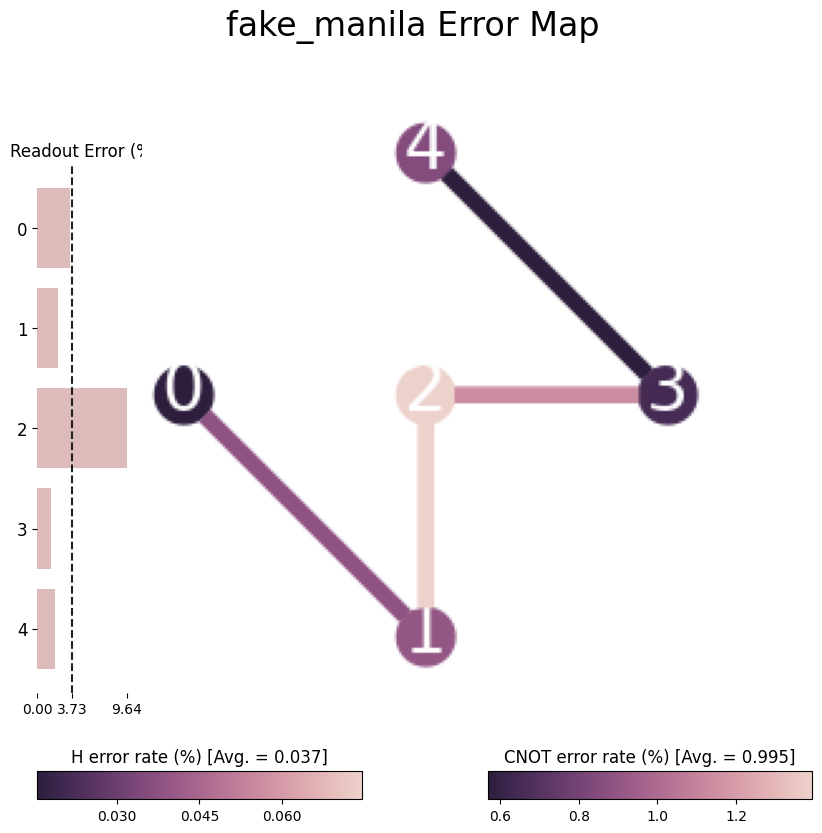

In [6]:
# Draw struct of backend
# using fakebackend or using aer simulator
from qiskit.visualization import plot_error_map
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
plot_error_map(FakeManilaV2(), figsize=(10,10))

Create benchmark

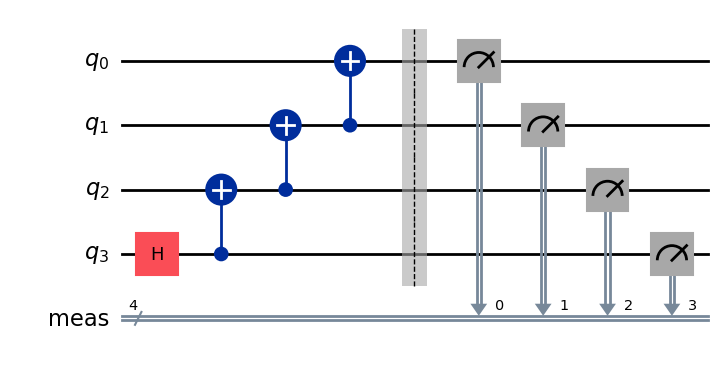

In [1]:
# create benchmark circuit
# Save the benchmark circuit to the disk(not yet) https://docs.quantum.ibm.com/guides/save-circuits

from component.b_benchmark.mqt_tool import benchmark_circuit

circuitTest = benchmark_circuit("ghz", 4)
circuitTest.draw("mpl")

Cutting circuit

In [9]:
# Cutting circuit here
from component.c_circuit_work.cutting.width_c import has_measurement
import numpy as np
if (has_measurement(circuitTest)):
    circuitTest.remove_final_measurements()
    
circuitTest.draw("mpl")
from qiskit.quantum_info import SparsePauliOp
observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])

from qiskit_addon_cutting import partition_problem
partitioned_problem = partition_problem(
    circuit=circuitTest, partition_labels="AABB", observables=observable.paulis
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases

from qiskit_addon_cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)
backend = FakeManilaV2()
from qiskit.transpiler import generate_preset_pass_manager
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}
from qiskit_ibm_runtime import SamplerV2, Batch

# Submit each partition's subexperiments to the Qiskit Runtime Sampler
# primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }
    
results = {label: job.result() for label, job in jobs.items()}
from qiskit_addon_cutting import reconstruct_expectation_values

# Get expectation values for each observable term
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)

# Reconstruct final expectation value
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)
from qiskit_aer.primitives import EstimatorV2

estimator = EstimatorV2()
exact_expval = estimator.run([(circuitTest, observable)]).result()[0].data.evs
print(f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}")
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: 0.87403321
Exact expectation value: 1.0
Error in estimation: -0.12596679
Relative error in estimation: -0.12596679


# Apply scheduling to the benchmark circuits as require ment

In [27]:
# Configuration
# 1. Number of Jobs in the batch
jobs = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5}
# 2. Number of machines
machines = {"QUITO": 5, "BELEM": 5}
# 3. Scheduling type

In [28]:
# Setup
bigM = 1000000
timesteps = 2**5

from component.d_scheduling.algorithm.ilp.MILQ_extend import MILQ_extend_implementation

In [69]:
# Scheduler
MILQ_extend_implementation.example_problem(bigM, timesteps, "component/d_scheduling/algorithm/ilp/MILQ_extend/MILQ_extend_result")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/trieu/anaconda3/envs/squan/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/c249a8ba49bc4d56aaca3411f026f1be-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/c249a8ba49bc4d56aaca3411f026f1be-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 710 COLUMNS
At line 4649 RHS
At line 5355 BOUNDS
At line 5860 ENDATA
Problem MODEL has 705 rows, 514 columns and 2929 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 11 - 0.00 seconds
Cgl0002I 8 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 495 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 400 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 223 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 176 strengthened rows, 0 sub

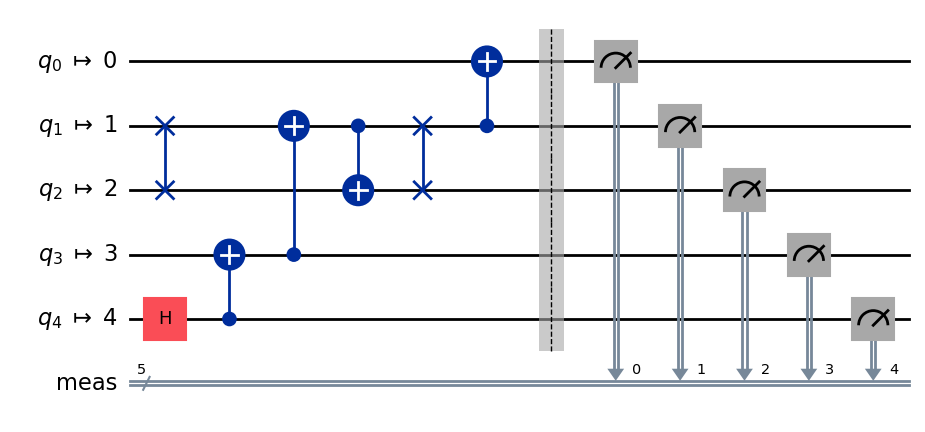

In [43]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeBelemV2
from qiskit.transpiler import generate_preset_pass_manager
 
backend = FakeBelemV2()
target = backend.target
coupling_map = target.build_coupling_map()
pass_manager = generate_preset_pass_manager(
    optimization_level=0, coupling_map=coupling_map, seed_transpiler=12345
)
qc_t_cm_lv0 = pass_manager.run(circuitTest)
qc_t_cm_lv0.draw("mpl", idle_wires=False, fold=-1)
 

In [ ]:
#mapping the scheduling result to the machine
# check qiskit_102, check qiskit transpiler

# after have the circuit we connect to
from qiskit.visualization import plot_circuit_layout
 
# Plot the hardware graph and indicate which hardware qubits were chosen to run the circuit
transpiled_circ = pass_manager.run(circuitTest)
plot_circuit_layout(transpiled_circ, backend)

NameError: name 'pass_manager' is not defined

  job  qubits machine  capacity  start   end  duration
0   A       2   QUITO         5    0.0  14.0      14.0
1   B       3   QUITO         5    0.0   8.0       8.0
2   C       5   BELEM         5    0.0  20.0      20.0
3   D       2   QUITO         5    9.0  21.0      12.0


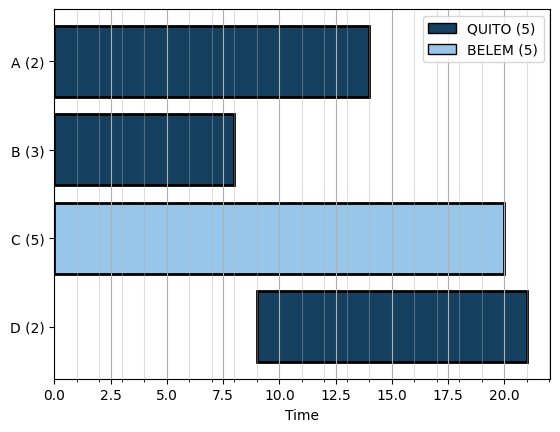

In [ ]:
# Visualize
from component.d_scheduling.visualize import ilp

ilp.visualize("component/d_scheduling/algorithm/ilp/MILQ_extend/MILQ_extend_result.json")


In [ ]:

# Analyze


